# Chapter 1: 統計モデルと因果モデル
## Agenda

- 因果の実践的な定義
- 因果関係を正確に記述する方法（因果モデルの作成）
- 因果モデルの構造をデータの特徴に関連づける方法
- モデルとデータに含まれる因果関係の組み合わせから結論を導く方法


In [ ]:
## create the clean environment
import gc
import matplotlib.pyplot as plt

def clear_all():
    # Clears all the variables from the workspace
    gl = globals().copy()
    for var in gl:
        if var in clean_env_var: continue
        del globals()[var]
    # Garbage collection:
    gc.collect()

def close_plots():
  my_plots = plt.get_fignums()
  for j in my_plots:
    plt.close(plt.figure(j))

clean_env_var = dir()
clean_env_var.append('clean_env_var')

In [ ]:
clear_all()

### Hardware

In [ ]:
%%bash
system_profiler SPHardwareDataType | grep -E \
"Model Identifier"\|"Processor Name"\|"Processor Speed"\
\|"Number of Processors"\|"Memory:"

### Python

In [3]:
!Python -V

Python 3.7.4


### Install Packages

In [2]:
pass

### Moduleの読み込み

In [264]:
import numpy as np
import random
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
from scipy import stats as stats
import seaborn as sns
from causalgraphicalmodels import CausalGraphicalModel
from scipy.stats import kstest

## Simpsonのパラドックス

- 全体集合で確認されるある統計的関係が、どの部分集合でも逆になるというもの

以下の例を考える。700人の患者について、350人は薬の投与を望み、半分は望まなかった。このとき、

- 男性は投薬グループ93%回復、薬投与なしグループは87%, sample sizeはそれぞれ87, 270
- 女性は投薬グループ73%回復、薬投与なしグループは69%, sample sizeはそれぞれ263, 80


In [57]:
def generate_simpson_data():
    """
    [OUTPUT]
        result: 1 if recovered, 0 otherwise
        gender: 1 if female
        treatment_status: 1 if treated
    """
    col = ['result', 'treatment', 'gender']
    male_treated = (87, 0.93, 1, 0)
    male_control = (270, 0.87, 0, 0)
    female_treated = (263, 0.73, 1, 1)
    female_control = (80, 0.69, 0, 1)
    
    result = np.random.choice(2, male_treated[0], p=[1 - male_treated[1], male_treated[1]])
    treatment_status = np.ones(male_treated[0]) * male_treated[2]
    gender_status = np.ones(male_treated[0]) * male_treated[3]
    stacked_data = np.stack([result, treatment_status, gender_status], axis = 1)
    
    for data in [male_control, female_treated, female_control]:
        result = np.random.choice(2, data[0], p=[1 - data[1], data[1]])
        treatment_status = np.ones(data[0]) * data[2]
        gender_status = np.ones(data[0]) * data[3]
        stacked_data_2 = np.stack([result, treatment_status, gender_status], axis = 1)
        stacked_data = np.vstack([stacked_data, stacked_data_2])
    
    return pd.DataFrame(stacked_data, columns = col, dtype = np.int)

In [49]:
simpson_df = generate_simpson_data()

In [54]:
simpson_df.groupby(['treatment', 'gender']).agg({'count', 'mean'})

result      
                      mean count
treatment gender                
0         0       0.862963   270
          1       0.762500    80
1         0       0.873563    87
          1       0.783270   263

In [56]:
simpson_df.groupby('treatment')['result'].mean()

treatment
0    0.840000
1    0.805714
Name: result, dtype: float64

### Monty Hall Problem

ここではまずMonty hall Problemの扉を変えた方が成功確率が高くなることを証明する。

- 扉はa, b, cの三つ
- 問題の簡略化のため、自分は扉aを選択した状況を考える
- event, A, B, Cはそれぞれ、司会者がa, b, cの扉を開けて、ガラクタが入っていた確率を示す
- P(a): 扉aが正解の確率

今、自分が扉aを最初に選択して、その後司会者が扉bを開けてガラクタを見せてくれた( = event B発生)状況を考える。このとき、自分が知りたいのは

$$
P(a|B)
$$

ベイズの定理を利用すると、

$$
\begin{aligned}
p(a|B) &= \frac{P(B|a)p(a)}{P(B)}\\
7 = \frac{1/2 \cdot 1/3}{P(B)}
\end{aligned}
$$

$$
P(B) = P(B, a) + P(B, b) + P(B, c)
$$

に留意すると

$$
P(B) = \frac{1}{2}\frac{1}{3} + 0\cdot\frac{1}{3} + 1\cdot \frac{1}{3} = \frac{1}{2}
$$

Then,

$$
p(a|B) = \frac{1}{3}
$$

一方、
$$
p(c|B) = \frac{P(B|c)p(c)}{P(B)} = \frac{1/3}{1/2} = \frac{2}{3}
$$










### Simulate Monty Hall Problem

- ドアを番号で分ける（1, 2, 3）
- 司会者は残りのドアが二つになるまで開け続ける

In [114]:
def monty_hall_trial(num_door, switch):
    correct_door = np.random.randint(0, num_door)
    chosen_door = np.random.randint(0, num_door)
    door_candidate = list(np.arange(num_door))
    
    if switch:
        remover = np.random.choice(num_door, num_door, replace=False)
        i = 0
        while len(door_candidate) > 2:
            tmp = remover[i]
            i += 1
            if tmp in (correct_door, chosen_door):
                continue
            else:
                door_candidate.remove(tmp)
        
        door_candidate.remove(chosen_door)
        chosen_door = door_candidate.pop()
        
    if chosen_door == correct_door:
        return True
    else:
        return False
    
def main_simulation(trials = 1000, num_door = 3):
    switch_result = []
    stick_result = []
    for i in range(trials):
        switch = monty_hall_trial(num_door = num_door, switch = True)
        stick = monty_hall_trial(num_door = num_door, switch = False)
        switch_result.append(switch)
        stick_result.append(stick)
    
    return switch_result, stick_result

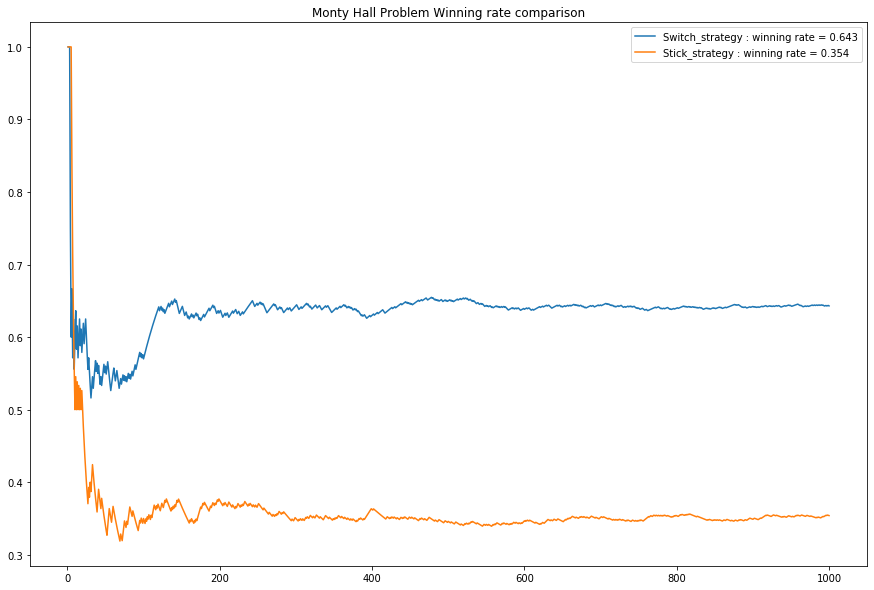

In [131]:
np.random.seed(42)
switch, stick = main_simulation(trials = 1000, num_door = 3)
cum_switch = np.cumsum(switch)
cum_stick = np.cumsum(stick)

x_label = np.arange(1, len(stick)+1)

plt.figure(figsize = (15, 10))

plt.plot(x_label, cum_switch/x_label, label = 'Switch_strategy : winning rate = {}'.format(np.mean(switch)))
plt.plot(x_label, cum_stick/x_label, label = 'Stick_strategy : winning rate = {}'.format(np.mean(stick)))
plt.title('Monty Hall Problem Winning rate comparison')
plt.legend();

## ベイズの定理
### False positive and False negative

コロナの罹患率を検査するための手法の一つであるPCR検査は検出力が80%,特異度が99%(true negative rate)とする。コロナ感染者率が10%の時、PCR検査でpositive判定が出たときの、コロナ罹患率を計算せよ

- T: tested positive event
- A: COVID-19罹患 event

$$
P(A|T) = \frac{P(T|A)P(A)}{P(T|A)P(A) + P(T|~A)P(~A)} = \frac{0.8 \cdot 0.1}{(0.8 \cdot 0.1) + (0.01 \cdot (1 - 0.1))} = 0.89
$$

In [149]:
def calculate_bayes_prob(prob, statistical_power = 0.8, false_positive = 0.01, trial = 1):
    numerator = prob * (statistical_power ** trial)
    denominator = numerator + (false_positive ** trial) * (1 - prob)
    return numerator/denominator

In [155]:
calculate_bayes_prob(0.1, trial = 1)

0.898876404494382

### カジノとbet

街のカジノで、2枚のコインを同時に投げて賞金を決める。プレーヤーは二人。

- プレーヤー1は少なくとも一つのコインが表である場合に限り１ドルを受け取る
- プレーヤー２は住まいとも同じ面である場合に限り1ドルを受け取る

プレーヤー１と２の獲得賞金をそれぞれX, Yとする。

プレーヤー1が10ドル受け取ったときのプレーヤー２の獲得賞金の期待値を求めよ。

In [252]:
class Simuate_Casino():
    """
    head: 1
    tail; 0
    """
    
    def __init__(self, x, y):
        self.winning_player_1 = x
        self.winning_player_2 = y
        self.trial_num = 0
    
    def start_game(self):
        a, b = self.flip_coin()
        self.trial_num += 1
        if max(a, b)>0:
            self.winning_player_1 += 1
        
        if a == b:
            self.winning_player_2 += 1
    
    def simulation(self, player, condition):
        if player == 1:
            while self.winning_player_1 < condition:
                self.start_game()
        
        elif player == 2:
            while self.winning_player_2 < condition:
                self.start_game()
            
    @staticmethod
    def flip_coin():
        a, b = np.random.choice(2, 2)
        return a, b

#### simulation

trialを1000回実施する

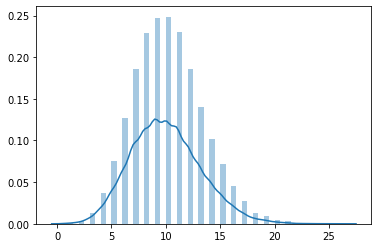

In [261]:
trial_num = 10000
sim_res = []
trial_log = []
for i in range(trial_num):
    trial = Simuate_Casino(x = 0, y = 0)
    trial.simulation(player = 1, condition = 15)
    res = trial.winning_player_2
    sim_res.append(res)
    trial_log.append(trial.trial_num)

sns.distplot(sim_res);

In [262]:
np.mean(sim_res)

10.016

In [263]:
np.mean(trial_log)

20.0251

#### 解き方

trial回数一回の時

$$
\begin{aligned}
&p(x = 1) = \frac{3}{4}\\
&p(y = 1) = \frac{1}{2}\\
&p(x=1|y=1) = \frac{p(x=1,y=1)}{p(y=1)} = \frac{p(x=1|y=1)p(y=1)}{p(y=1)} = \frac{1}{2}\\
&p(y=1|x=1) = \frac{1}{3}
\end{aligned}
$$

$x = 10$までの試行回数の期待値は負の二項分布より

$$
E[n] = \frac{10}{P(x=1)} = \frac{40}{3}
$$

Then,

$$
E[y|x = 10] = E[n]*p(y=1) = \frac{20}{3}
$$




### Bayesian methodとコインの裏表の確率

- q: the probability of being flipped head
- set the prior $p \sim Unif(0, 1)$
- $\{x_i\}$: data
- i: index (unit of observation)
- n: trial回数
- h: 表が出た回数

the posterior distibution can be calculated as follows:

$$
P(q|\{x_i\}) = \frac{P(\{x_i\}|q)P(q)}{\int^1_0 P(\{x_i\}|q)P(q)dq}
$$


ここで

$$
\begin{eqnarray}
\int_0^1 p^k(1-p)^{n-k} &=& \frac{1^{k+1}(1-1)^{n-k}}{k+1}-\frac{0^{k+1}(1-0)^{n-k}}{k+1}+\frac{n-k}{k+1}\int_0^1 p^{k+1}(1-p)^{n-k-1}\\
&=& \frac{n-k}{k+1}\int_0^1 p^{k+1}(1-p)^{n-k-1}\\
&=& \frac{(n-k)(n-k-1)}{(k+1)(k+2)}\int_0^1 p^{k+2}(1-p)^{n-k-2}\\
&\vdots&\\
&=& \frac{k!(n-k)!}{n!}\int_0^1 p^{n}=\frac{k!(n-k)!}{n!}\frac{1}{n+1}=\frac{k!(n-k)!}{(n+1)!}\\
\end{eqnarray}
$$

よって、
$$
P(q|\{x_i\}) = \frac{P(\{x_i\}|q)P(q)}{\int^1_0 P(\{x_i\}|q)P(q)dq} = (n+1)\frac{n!}{h(n-h)!}q^h(1-q)^{n-h}
$$


#### simulation

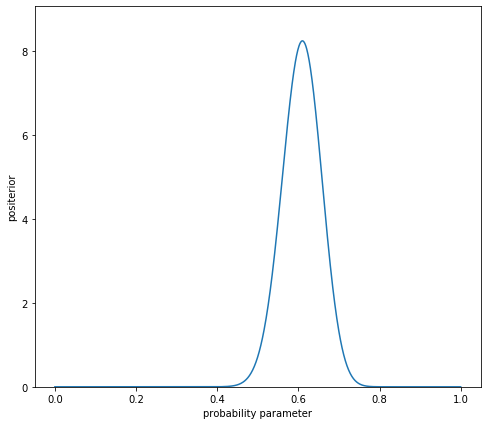

In [271]:
def calculate_posterior(n, h, q):
    return (n+1)*st.binom(n, q).pmf(h)

n = 100
h = 61
q = np.linspace(0., 1., 1000)
d = calculate_posterior(n, h, q)

fix, ax = plt.subplots(1, 1, figsize = (8, 7))
ax.plot(q, d)
ax.set_xlabel('probability parameter')
ax.set_ylabel('positerior')
ax.set_ylim(0, d.max()*1.1);

Maximum a posteriori estimationはposterior distributionをparameterのFOCを求めることで解析的に取得できる。

つまり、

$$
(n+1)\frac{n!}{(n-h)!h!}\left(hq^{h-1}(1-q)^{n-h} - (n-h)q^h(1-q)^{n-h-1}\right) = 0
$$

を解く。

よって、$q^* = h/n$


## 構造的因果モデル
### グラフ

- グラフはnodeとedgeで構成される集合体のこと
- 無向グラフと有向グラフがある（Causal Graphは非循環的な有向グラフ）

### 構造的因果モデル

構成要素は以下、

- 変数集合UとV
- U: 外生変数の集合
- V: 内生変数の集合（モデルに使う内生変数は、少なくとも1つの外生変数の子孫になっている）
- f: モデル内の他の変数の値によってVそれぞれの変数の値を決定する関数の集合